<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/Tacha/CalcificationTestImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
# just once to install opencv
!pip install opencv-python

In [2]:
# just once to install matplotlib
!pip install matplotlib

In [3]:
# just once to install numpy
!pip install numpy

In [ ]:
# just once to install google.colab
#!pip install google-colab

In [ ]:
#!pip install PyWavelets

In [ ]:
#!pip install image_dehazer

In [9]:
!pip install -U scikit-image

In [8]:
#!pip install fastprogress
from fastprogress import master_bar, progress_bar

In [10]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [12]:
# os.listdir(DATA_DIR + "/groundtruths")

In [13]:
# import opencv
import cv2
# import numpy
import numpy as np


# Preprocessing

In [14]:
# preprocessing
# here explain what you code
def preprocessingWavelet(matrix, mask):
  # wavelet high pass, low pass or low pass, high pass, high pass high pass.
  import pywt  

  # enhancement
  # Comparing the Performance of Image Enhancement Methods
  # to Detect Microcalcification Clusters in Digital Mammography, Moradmand, Hajar, 2012

  # Five-level   discrete   wavelet decomposition  was  employed  by  using  Asymmetric Daubechies  of  order  8; 

  # normal wavelet from stackoverflow
  # convert to grayscale
  grayscale = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)

  # convert to float
  arrayFloat = np.float32(grayscale)
  arrayFloat /= 255
  
  # compute coefficients
  coeffs = pywt.wavedec2(arrayFloat,'haar',level=10)

  #process coefficients
  coeffs_H = list(coeffs)
  coeffs_H[0] *= 0

  # reconstruction
  arrayFloat_H = pywt.waverec2(coeffs_H, 'haar')
  arrayFloat_H *= 255
  arrayFloat_H = np.uint8(arrayFloat_H)

  preprocessed = arrayFloat_H
  return preprocessed

In [15]:
# preprocessing
# here explain what you code
def preprocessingDeHazingPy(matrix, mask):
  # https://link.springer.com/chapter/10.1007/978-3-319-68548-9_27
  # the professor say we can take the grays in the mammogram as haze. so use dehazing

  # still no the hazing method that he use this is just one found in a python library
  # https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python
  # dehazing

  import image_dehazer	# Load the library

  hazeCorrectedImg = image_dehazer.remove_haze(matrix)		# Remove Haze

  preprocessed = hazeCorrectedImg
  return preprocessed

In [16]:
# dehaze single image using dark channel prior and guided filter
# taken from a repository 
# https://github.com/He-Zhang/image_dehaze
# dehazing method proposed by the professor 
# simple imaging dehazing using dark channel prior (and guided filter, readme.md of the repo say that)
import math

# change this methods to do just grayscale will be nice

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;# the closer to 1 the stronger the darkenning
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
    return res

def deHazingDarkChannelPriorPy(matrix, mask):

    I = matrix.astype(np.float64)/255
 
    dark = DarkChannel(I,15)
    A = AtmLight(I,dark)
    te = TransmissionEstimate(I,A,15)
    t = TransmissionRefine(matrix,te)
    J = Recover(I,t,A,0.1)
    preprocessed = J
    return preprocessed

# image = cv2.imread(DATA_DIR+"/images/53582422_3f0db31711fc9795_MG_R_ML_ANON.tif")
# dark, t, matrix, J = deHazingDarkChannelPriorPy(image, image)


### Image Dilation

In [40]:
def imgDilation(matrix):
  kernel = np.ones((9,9), np.uint8)
  img_dilation = cv2.dilate(matrix, kernel, iterations=3)
  return img_dilation

### De-noising

In [42]:
def gaussianBlur(matrix):
  img_blurred = cv2.GaussianBlur(matrix, (5,5), 0)
  return img_blurred

# Candidate Extraction

###Hessian-Matrix-Based Analysis

In [18]:
# candidateExtraction
# here explain what you code
# Hessian-matrix-based analysis or difference of gaussians (DoH) blob detection from skimage
# https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_doh
def candidateExtraction(matrix, mask):

  from skimage import feature

  # returns x,y,sigma of the blob
  blobs = feature.blob_doh(matrix,
                           min_sigma=1,
                           max_sigma=30,
                           num_sigma=10,
                           # The absolute lower bound for scale space maxima.
                           # Local maxima smaller than threshold are ignored.
                           # Reduce this to detect blobs with lower intensities.
                           # If threshold_rel is also specified, whichever threshold is larger will be used.
                           # If None, threshold_rel is used instead.
                           threshold=0.005,
                           # lower more sensible, more false positives bad also tinier calcifications detected
                           overlap=0.5,
                           log_scale=False,
                           threshold_rel=None
                           )
  # taken from the documentation
  # ...The downside is that this method can’t be used for detecting blobs of radius less than 3px
  # due to the box filters used in the approximation of Hessian Determinant.
  result = blobs
  return result

### Difference of Gaussians

In [26]:
# https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_dog

def candidateExtractionDoG(matrix, mask):
  from skimage import data, feature

  blobs = feature.blob_dog(matrix,
                           threshold=.005,
                           min_sigma=1,
                           max_sigma=30)
  result = blobs
  return result

# Feature Extraction

In [19]:
# Get Ground Truth for each patch

def patchGroundTruth(candidate, groundTruth):

  left = int((candidate[0] - candidate[2]) if ((candidate[0] - candidate[2]) > 0) else 0)
  right = int((candidate[0] + candidate[2]) if ((candidate[0] + candidate[2]) < groundTruth.shape[0]) else groundTruth.shape[0])
  top = int((candidate[1] - candidate[2]) if ((candidate[1] - candidate[2]) > 0) else 0)
  bottom = int((candidate[1] + candidate[2]) if ((candidate[1] + candidate[2]) < groundTruth.shape[1]) else groundTruth.shape[1])

  truePatch = groundTruth[left : right,
                          top  : bottom]
  sum = np.sum(truePatch)
  if sum > 0:
    return str(1)
  else:
    return str(0)
    

In [20]:
from skimage import feature
import itertools

# featuresExtraction
# here explain what you code
def featuresExtraction(matrix, candidates, features, mask, groundTruth, image):
  
  if (len(candidates) == 0):
    return []
  # angles
  #         0     45      90       135
  angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

  # https://www.youtube.com/watch?v=5x-CIHRmMNY
  # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html
  # https://ijcrr.com/uploads/3454_pdf.pdf

  flag = True
  for index, candidate in enumerate(progress_bar(candidates)):
    
    # distances
    # taking into account the microcalcifications can be less that 5 pixels

    #https://www.sciencedirect.com/topics/engineering/cooccurrence-matrix
    #distances = [1,3,5,7]
    # read more about the variation of distances in glcm computation
    distances = [1]# probably we need bigger

    # combination of distances and angles as couples of values
    distancesAngles = list(itertools.product(distances, angles))

    # candidate points are save as np.float64
    # to use them as coordinates they have to be integers
    candidate = candidate.astype(np.int64)

    # candidates are y,x and sigma
    left = int((candidate[0] - candidate[2]) if ((candidate[0] - candidate[2]) > 0) else 0)
    right = int((candidate[0] + candidate[2]) if ((candidate[0] + candidate[2]) < matrix.shape[0]) else matrix.shape[0])
    top = int((candidate[1] - candidate[2]) if ((candidate[1] - candidate[2]) > 0) else 0)
    bottom = int((candidate[1] + candidate[2]) if ((candidate[1] + candidate[2]) < matrix.shape[1]) else matrix.shape[1])

    patchCandidate = matrix[left: right,
                            top : bottom]
    # reduce even more the shades of gray T-T
    # graycomatrix, glcm, receive unsigned integer type
    # but if it is bigger that np.uint8 you have to change the levels argument
    # of graycomatrix for the shades of gray, if it is np.uint16, levels shoud be
    # aprox 65 535. that break the colab :c 
    patchCandidate = patchCandidate.astype(np.uint8)
    dictFeatures = {}
    dictFeatures = {'name': 'patch_' + str(index) + '_' + str(image.split(".")[0]),
                    'label': patchGroundTruth(candidate, groundTruth)}
    #print("patch_"+str(index))
    #print(patchCandidate)

    for distanceAngle in distancesAngles:
      distance = distanceAngle[0]
      angle = distanceAngle[1]
      # get the degree to use it as name for the column
      name = str(angle*(180.0/np.pi))
      # input image, distance in pixels, angles
      #https://stackoverflow.com/questions/54512617/creating-gray-level-co-occurrence-matrix-from-16-bit-image
      glcm = feature.graycomatrix(patchCandidate, [ distance ], [ angle ])

      # Output: the gray-level co-occurrence histogram. The value P[i,j,d,theta]
      # is the number of times that gray-level j occurs at a distance d
      # and at an angle theta from gray-level i.
      # If normed is False, the output is of type uint32, otherwise it is float64.
      # The dimensions are: levels x levels x number of distances x number of angles.

      # properties: {‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’}
      dictFeatures['contrast'+ str(distance) + name] = feature.graycoprops(glcm, 'contrast')[0][0]
      dictFeatures['dissimilarity' + str(distance) + name] = feature.graycoprops(glcm, 'dissimilarity')[0][0]
      dictFeatures['homogeneity' + str(distance) + name] = feature.graycoprops(glcm, 'homogeneity')[0][0]
      dictFeatures['energy' + str(distance) + name] = feature.graycoprops(glcm, 'energy')[0][0]
      dictFeatures['correlation' + str(distance) + name] = feature.graycoprops(glcm, 'correlation')[0][0]
      dictFeatures['ASM' + str(distance) + name] = feature.graycoprops(glcm, 'ASM')[0][0]

      # print(feature.graycoprops(glcm, 'contrast')[0][0])
      # print(feature.graycoprops(glcm, 'dissimilarity')[0][0])
      # print(feature.graycoprops(glcm, 'homogeneity')[0][0])
      # print(feature.graycoprops(glcm, 'energy')[0][0])
      # print(feature.graycoprops(glcm, 'correlation')[0][0])
      # print(feature.graycoprops(glcm, 'ASM')[0][0])

      # https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.graycoprops
      # Compute a feature of a gray level co-occurrence matrix to serve as a compact summary of the matrix.
      # The properties are computed as follows:
      # contrast
      # dissimilarity
      # homogeneity
      # ASM
      # energy
      # correlation
    # add to the dataframe the features for this patch
    features = features.append(dictFeatures, ignore_index=True)
    # save in the csv

  # if(flag):
  #   features.to_csv(os.path.join('/content',
  #                               'drive',
  #                               'MyDrive',
  #                               'Results',
  #                               str(image.split('.')[0]) + '_features.csv'),
  #                   mode='a',
  #                   index=False)
  #   flag = False
  # else:
  #   features.to_csv(os.path.join('/content',
  #                               'drive',
  #                               'MyDrive',
  #                               'Results',
  #                               str(image.split('.')[0]) + '_features.csv'),
  #                 mode='a',
  #                 header=False,
  #                 index=False)



  return features

# Connected Components

In [21]:
# function to get connected components of the ground truth binary image
def componentsStatsGroundTruth(matrix):
    # getting the info of the components in the ground truth
    # second value is connectivity 4 or 8
    connectedComponentsGroundTruth = cv2.connectedComponentsWithStats(matrix, 8, cv2.CV_32S)

    # Get the results
    # The first cell is the number of labels
    num_labels = connectedComponentsGroundTruth[0]
    # The second cell is the label matrix
    labels = connectedComponentsGroundTruth[1]
    # The third cell is the stat matrix
    stats = connectedComponentsGroundTruth[2]
    # The fourth cell is the centroid matrix
    centroids = connectedComponentsGroundTruth[3]

    return num_labels, labels, stats, centroids

# Get Info from Drive

In [22]:
#import show special for google colab
from google.colab.patches import cv2_imshow
#import plt for display
import matplotlib.pyplot as plt

#go into de directory of the images

# this have 3 outputs root directory, the folders in the path and the files in the path.
# we ignore _ the two first because we are not interested in those
_, _, images = next(os.walk(os.path.join(DATA_DIR,'images')))
_, _, breastMasks = next(os.walk(os.path.join(DATA_DIR,'masks')))
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

images.sort()
breastMasks.sort()
groundTruths.sort()

# read numbers of normal images
normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])



# Google Colab like a Pro

In [23]:
# https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573#a642
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

# Show Images

In [24]:
from matplotlib.patches import Circle
import matplotlib.patches as mpatches

# function to draw the grid to display
def display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features):
  # draw in the axis the img
  axis[0][0].imshow(img)
  # switch off the axis of the plot
  axis[0][0].axis('off')
  # set a title for the plot
  axis[0][0].set_title('Image')

  axis[0][1].imshow(imgGroundTruth, cmap='gray')
  axis[0][1].axis('off')
  axis[0][1].set_title('Ground Truth')

  axis[0][2].imshow(imgMask)
  axis[0][2].axis('off')
  axis[0][2].set_title('Breast Mask')

  axis[1][0].imshow(preprocessed, cmap='gray')
  axis[1][0].axis('off')
  axis[1][0].set_title('Preprocessed')

  # draw candidates as circles
  axis[1][1].imshow(preprocessed, cmap='gray')
  axis[1][1].axis('off')
  axis[1][1].set_title('Candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for y,x,sigma in candidates:

    blob = Circle((x,y), sigma*5, color='blue', fill=False)
    axis[1][1].add_patch(blob)

    rect=mpatches.Rectangle((x,y),sigma,sigma, 
                        fill=False,
                        color="red",
                       linewidth=2)
    axis[1][1].add_patch(rect)


  axis[1][2].imshow(imgGroundTruth, cmap='gray')
  axis[1][2].axis('off')
  axis[1][2].set_title('compare with ground truth and candidates')

  # Now, loop through coord arrays, and create a circle at each x,y pair
  for y,x,sigma in candidates:
    blob = Circle((x,y), sigma, color='blue', fill=False)
    axis[1][2].add_patch(blob)
  
  return figure, axis


# Main

image:  24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


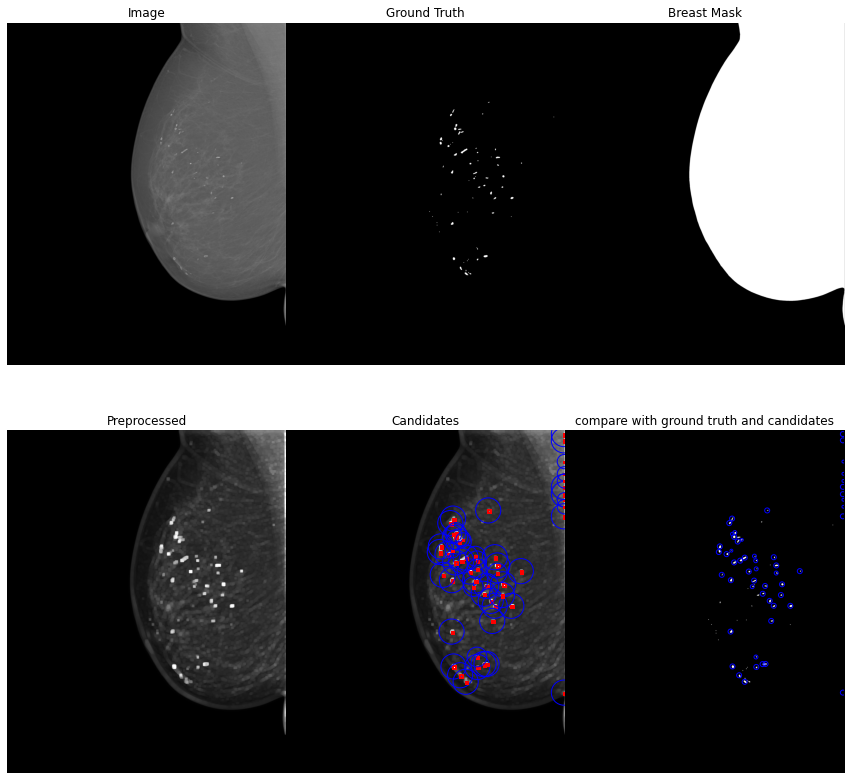

In [43]:
import copy
import pandas as pd

#go through the image files 
for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):
  # choose one
  # this are the last 4 of the number of the image name {numbers}_{}_{}_{}_{}_{}.tif
  # i suppose those are unique
  # if your code is working try other images!
  #print(breastMask)
  
  # restart variables for memory

  # to save the features generated with the glcm
  features = pd.DataFrame(dtype=np.float64)
  # to save the candidates
  blobs = {}
  # to sabe the ground truth connected components
  groundTruthsComponents = {}
  

  # 20588020, 7717, 5328, 3787, 5725, 3859, 6934, 50995872
  digits = '5328'

  if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
  #if ('mask' in breastMask):
  #if image not in already:
    print("image: ", image)
    #upload images
    img = cv2.imread(os.path.join(DATA_DIR,'images',image))
    imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMask))
    imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', image), cv2.IMREAD_GRAYSCALE)


    # processing necessary for evaluation

    # Get components of the ground truth
    '''
    num_labels, labels, stats, centroids = componentsStatsGroundTruth(imgGroundTruth)
    groundTruthsComponents[image] = {}
    groundTruthsComponents[image]['num_labels'] = num_labels
    groundTruthsComponents[image]['labels'] = labels
    groundTruthsComponents[image]['stats'] = stats
    groundTruthsComponents[image]['centroids'] = centroids
    '''
    # preprocessing #

    imgCopy = copy.deepcopy(img)

    # preprocessed = preprocessingDeHazingPy(img, imgMask)
    preprocessed = deHazingDarkChannelPriorPy(imgCopy, imgMask)
    preprocessed = gaussianBlur(preprocessed)
    preprocessed = imgDilation(preprocessed)
    # after preprocessingDeHazingPy + contrast streching to see
    # preprocessed = preprocessingDeHazingPy(imgCopy,imgMask)

      # still missing quantum noise supression
      # details in the phd defense file

      # still missing linear streching
        # keep going forever the code, computational cost

      # still missing CLAHE (adaptive histogram equalization) opencv library
        # CLAHE + dehazing bad results.
        # points less visible with CLAHE

        # dehazing + CLAHE 
        # black image

      # Observations from the results:

        # fiber intersections may also appear as bright spots (false positives)

      # THINGS WE NOTICE BETWEEN BOTH DEHAZING METHODS

        # Better suppression of fatty tissue (noise) and greater enhancement of brightness of desired feature (microcalcifications)

        # sometimes for the other dehazing method black patches become present in the fatty tissue
        # this did not happen in the dehazing with dark channel prior (and guided filter)

        # sharper

        # enhance the contrast

        # details were enhanced

    # candidate extraction #

    copyPreprocessed = copy.deepcopy(preprocessed)

    # we have to change np.float64 to np.float32 for the grayscale conversion
    # leading to a reduction of gray values
    copyPreprocessed = copyPreprocessed.astype(np.float32)
    copyPreprocessed = cv2.cvtColor(copyPreprocessed, cv2.COLOR_BGR2GRAY)

    candidates = candidateExtraction(copyPreprocessed, imgMask)

    # Observations from the results:

      # images with pectoral muscule cause false positives

    # feature extraction #

    features = featuresExtraction(copyPreprocessed, candidates, features, imgMask, imgGroundTruth, image)

    
    # machine learning must be applied for the classification of the features extracted

    # import gc

    # del features
    # del preprocessed
    # del candidates
    # # del blobs
    # del copyPreprocessed
    # del imgCopy
    # del img
    # del imgMask
    # del imgGroundTruth
    
    # gc.collect()
    
    # end image processing part #

    # processing necessary for evaluation #

    # save blobs results to check groundtruth
    blobs[image] = candidates


    # display related #

    # matrix of plots and size of the figure
    figure, axis = plt.subplots(2, 3, figsize=(15,15))

    display_grid(figure, axis, img, imgGroundTruth, preprocessed, candidates, features)
 
    plt.subplots_adjust(wspace=0, hspace=0)

    # # display figure with image
    plt.show()

    # # extract patches of candidates
    # for index, candidate in enumerate(candidates):
    #   print("candidate: ", index)
    #   left = int((candidate[0] - candidate[2]) if ((candidate[0] - candidate[2]) > 0) else 0)
    #   right = int((candidate[0] + candidate[2]) if ((candidate[0] + candidate[2]) < preprocessed.shape[0]) else preprocessed.shape[0])
    #   top = int((candidate[1] - candidate[2]) if ((candidate[1] - candidate[2]) > 0) else 0)
    #   bottom = int((candidate[1] + candidate[2]) if ((candidate[1] + candidate[2]) < preprocessed.shape[1]) else preprocessed.shape[1])

    #   plt.imshow(preprocessed[left:right, top:bottom])
    #   plt.show()

    # display image with other function
    #cv2_imshow(features)
    


In [ ]:
files = os.listdir("/content/drive/MyDrive/Results")
print(len(files))


403


In [ ]:
import copy
import pandas as pd

df = pd.DataFrame(columns=['names'])

#go through the image files 
for image, breastMask, groundTruth in zip(progress_bar(images), breastMasks, groundTruths):

  #if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
  if ('mask' in breastMask):
    
    df = df.append({'names': image}, ignore_index=True)


In [ ]:
import pandas as pd

features = pd.read_csv(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'names.csv'))

FileNotFoundError: ignored

In [ ]:

df.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'names.csv'))


In [ ]:
# save images
'''
cv2.imwrite(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                         'features.csv'),
            features)
'''

In [ ]:
# evaluation froc curve #

''''
fp = 0 # false positive, findings on normal images, don't forget the normals variable
tp = 0 # true positive, for the blobs that are inside a component
fn = 0 # false negative, for the blobs that do not belong to any component

for key in groundTruthsComponents:
  # list of features found with y,x and sigma
  featuresImg = blobs[key]
  
  # restart the variables
  fp = 0
  tp = 0
  fn = 0

  # is the image a normal image?
  if (key in normals):
    # if it is false positive
    fp = fp + 1
    continue

  # if it is not register as normal
  # stat have 5 items: leftmost x coordinate,
  #                    topmost y coordinate,
  #                    horizontal size of the bounding box
  #                    vertical size of the bounding box
  #                    total area in pixels of the connected component
  for centroid, stat in zip(groundTruthsComponents[key]['centroids'], groundTruthsComponents[key]['stats']):
    # remember one component is the background
    
    if (stat[0] == 0):
      # is the background
      continue

    # top left is the 0,0 of the image
    
    topX = stat[0]
    bottomX = stat[0] + stat[2]

    topY = stat[1]
    bottomY = stat[1] + stat[3]

    matchs = [1 for feature in featuresImg if (( feature[1] >= topX ) and
                                               ( feature[1] <= bottomX ) and
                                               ( feature[0] >= topY ) and
                                               ( feature[0] <= bottomY )) ]

    # true positives
    tp = tp + np.sum(matchs)


    #false negatives will be the difference between the total true positives and the blobs that we receive

  fn = len(featuresImg) - tp

  # save and compute tpr and fpr

  # to make te roc curve i need scores... clasification :|
'''

In [ ]:

features.to_csv( os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                        'features.csv'))
